# Is it People or Scenery?

## Step 1: Get Images

In [2]:
from fastcore.all import *

### Function to use DuckDuckGo to grab images

In [3]:
import time

def search_images(term, max_images=149):
#     if i put max_images greater than 149 it gives HTTP 403 error
    url = 'https://duckduckgo.com/'
    res = urlread(url,data={'q':term})
    searchObj = re.search(r'vqd=([\d-]+)\&', res)
    requestUrl = url + 'i.js'
    params = dict(l='us-en', o='json', q=term, vqd=searchObj.group(1), f=',,,', p='1', v7exp='a')
    urls,data = set(),{'next':1}
    while len(urls)<max_images and 'next' in data:
        data = urljson(requestUrl,data=params)
        urls.update(L(data['results']).itemgot('image'))
        requestUrl = url + data['next']
        time.sleep(0.2)
    return L(urls)[:max_images]

### Seeing if working 

In [4]:
urls = search_images('photos of people', max_images=1)
urls[0]

'https://images.unsplash.com/photo-1520024146169-3240400354ae?crop=entropy&cs=tinysrgb&fit=max&fm=jpg&ixid=MnwxMjA3fDB8MXxzZWFyY2h8NHx8Y29vbCUyMHBlb3BsZXx8MHx8fHwxNjE5Mjk2MjU3&ixlib=rb-1.2.1&q=80&w=1080'

### Viewing downloaded image

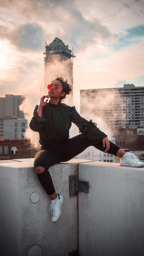

In [5]:
from fastdownload import download_url
dest = 'people.jpg'
download_url(urls[0], dest, show_progress=True)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)

https://wallpapercave.com/wp/3AjsGRD.jpg


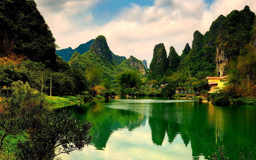

In [6]:
urls = search_images('photos of scenery', max_images=1)
print(urls[0])

dest = 'scenery.jpg'
download_url(urls[0], dest, show_progress=True)

im = Image.open(dest)
im.to_thumb(256,256)

### Download many images

In [8]:
## this gives error sometimes, just run it again.

searches = 'photos of people','photos of scenery'
path = Path('PeopleVsScenery')

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} photo'))
    resize_images(path/o, max_size=400, dest=path/o)

In [9]:
print(type(path))
for child in path.iterdir():
    print(child)
    print(type(child))

<class 'pathlib.PosixPath'>
PeopleVsScenery/photos of scenery
<class 'pathlib.PosixPath'>
PeopleVsScenery/photos of people
<class 'pathlib.PosixPath'>


In [10]:
# for main_item in path.iterdir():
#     print(main_item.name)
#     for item in main_item:
#         print(item.name)

for item in path.iterdir():
     print(item.name)
        
#i could not figure out how to read the images from inside the path

photos of scenery
photos of people


## Step 2: Train Model

Some photos might not download correctly which could cause our model training to fail, so we'll remove them:

In [11]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

6

To train a model, we'll need DataLoaders, which is an object that contains a training set (the images used to create a model) and a validation set (the images used to check the accuracy of a model -- not used during training). In fastai we can create that easily using a DataBlock, and view sample images from it:

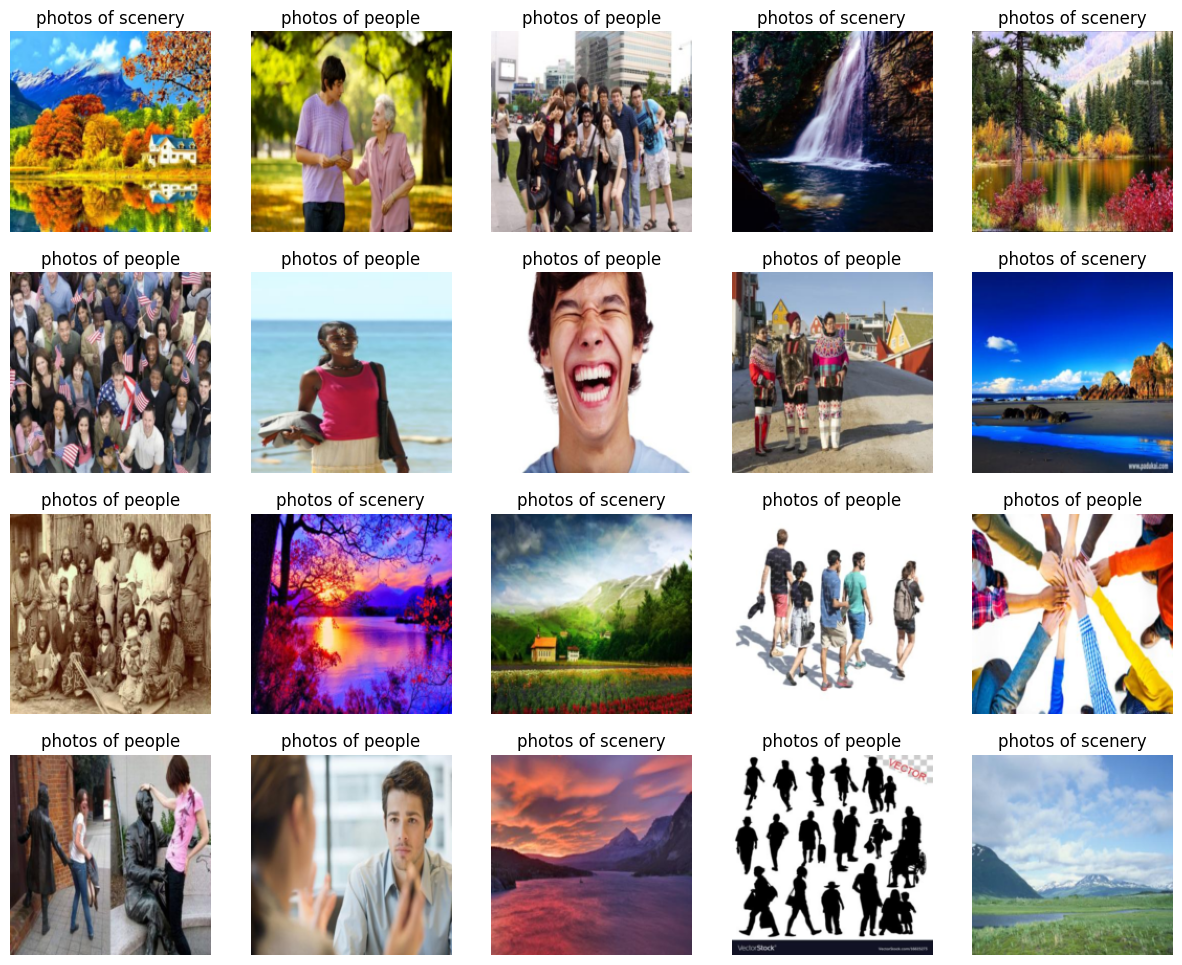

In [12]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path)

dls.show_batch(max_n=20)

Here's what each of the `DataBlock` parameters means:

```python
blocks=(ImageBlock, CategoryBlock),
```

The inputs to our model are images, and the outputs are categories (in this case, "photos of people" or "photos of scenery").

```python
get_items=get_image_files, 
```

To find all the inputs to our model, run the `get_image_files function` (which returns a list of all image files in a path).

```python
splitter=RandomSplitter(valid_pct=0.2, seed=42),
```

Split the data into training and validation sets randomly, using 20% of the data for the validation set.

```python
get_y=parent_label,
```

The labels (`y` values) is the name of the `parent` of each file (i.e. the name of the folder they're in, which will be photo of a car or photo of a damaged car).

```python
item_tfms=[Resize(192, method='squish')]
```

Before training, resize each image to 192x192 pixels by `"squishing"` it (as opposed to cropping it).

Now we're ready to train our model. The fastest widely used computer vision model is `resnet18`. You can train this in a few minutes, even on a CPU! (On a GPU, it generally takes under 10 seconds...)

`fastai` comes with a helpful `fine_tune()` method which automatically uses best practices for fine tuning a pre-trained model, so we'll use that.

Let's look at more of our downloaded photos:

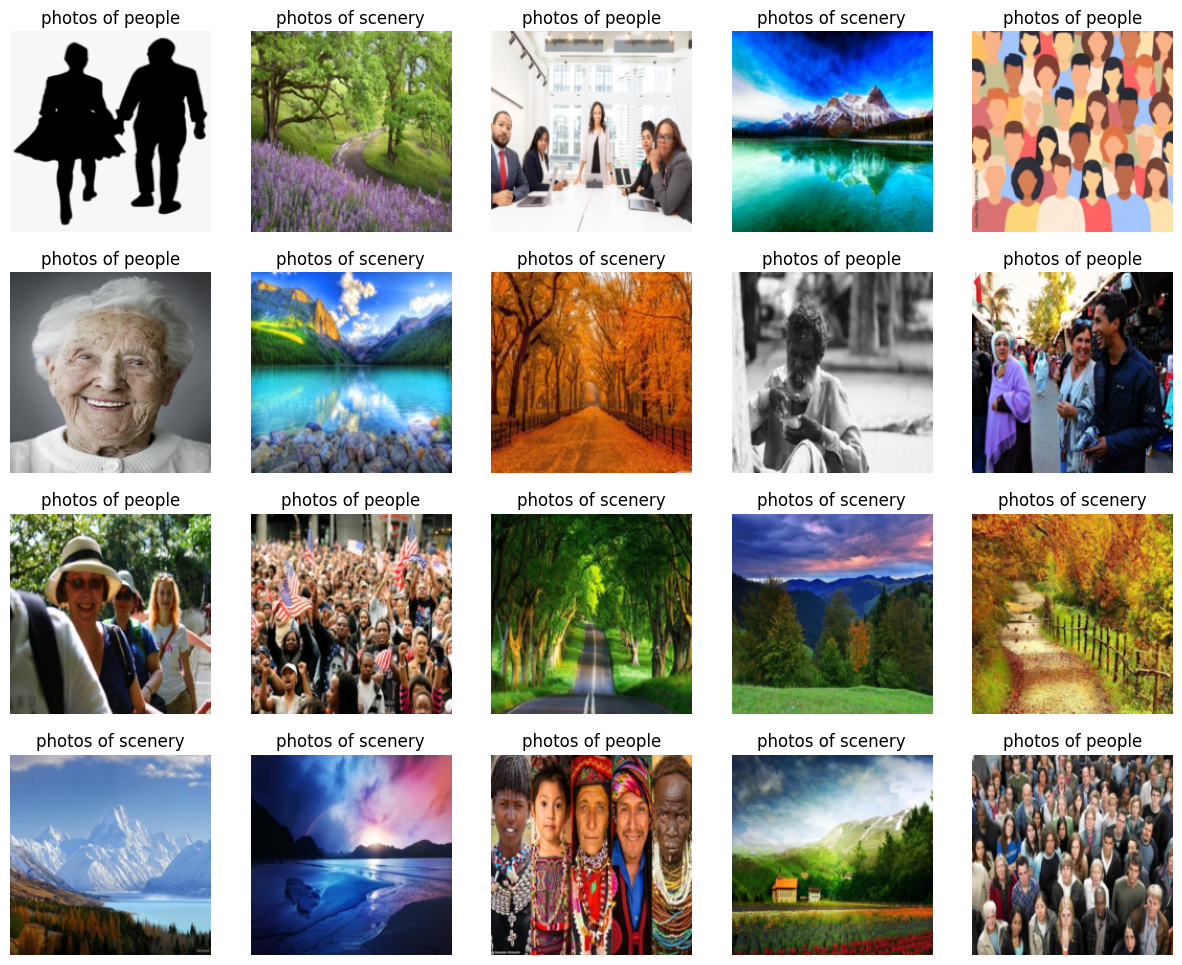

In [13]:
dls.show_batch(max_n=20)

In [14]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(30)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 113MB/s] 


This is my first project with the fast.ai course.

## Step 3: Use the Model

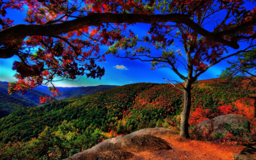

In [24]:
download_url(search_images('photo of scenery', max_images=1)[0], 'scenery.jpg', show_progress=False)
Image.open('scenery.jpg').to_thumb(256,256)

In [25]:
is_scenery,_,probs = learn.predict(PILImage.create('scenery.jpg'))
print(f"This is a: {is_scenery}.")
# print(f"Probability it's scenery: {probs[0]:.4f}")

This is a: photos of scenery.


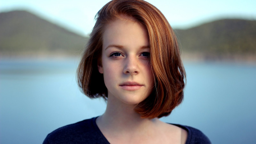

In [26]:
download_url(search_images('photo of people', max_images=1)[0], 'people.jpg', show_progress=False)
Image.open('people.jpg').to_thumb(256,256)

In [27]:
is_people,_,probs = learn.predict(PILImage.create('people.jpg'))
print(f"This is a: {is_people}.")
print(f"Probability it's people: {probs[0]:.4f}")

This is a: photos of people.
Probability it's people: 1.0000


## Finished!!